<a href="https://colab.research.google.com/github/shshyam147/DSEngineering/blob/main/Assignment_FeatureSelection_ShikaShyam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A comparison of predicting Parkinson's disease with Speech Data using Resilient Neural Networks, SVM, Linear Regression and Decision Trees

##Abstract

The Parkinson's telemonitoring dataset is a dataset that comprises of biomedical voice measurments from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes. 

Columns in the dataset contain subject number, subject age, subject gender, time interval from baseline recruitment date, motor UPDRS, total UPDRS, and 16 biomedical voice measures. Each row corresponds to one of 5,875 voice recording from these individuals. The main aim of the data is to predict the motor and total UPDRS scores ('motor_UPDRS' and 'total_UPDRS') from the 16 voice measures.

This notebook aims to analyze, visualize and determine the important features among these 20 features that can help us predict the two target variables, namely, motor_UPDRS and total_UPDRS and comparing the performance of various machine learning algorithms in predicting the same

Below is the data dictionary for this dataset:

1. subject# - Integer that uniquely identifies each subject 
2. age - Subject age 
3. sex - Subject gender '0' - male, '1' - female 
4. test_time - Time since recruitment into the trial. The integer part is the number of days since recruitment. 
5. motor_UPDRS - Clinician's motor UPDRS score, linearly interpolated 
6. total_UPDRS - Clinician's total UPDRS score, linearly interpolated 
7. Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP - Several measures of variation in fundamental frequency 
8. Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA - Several measures of variation in amplitude 
9. NHR,HNR - Two measures of ratio of noise to tonal components in the voice 
10. RPDE - A nonlinear dynamical complexity measure 
11. DFA - Signal fractal scaling exponent 
12. PPE - A nonlinear measure of fundamental frequency variation 

In [11]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from fitter import Fitter, get_common_distributions, get_distributions

The dataset that we will be using for this project is available on the UCI ML library at the below URL:
https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring

In [13]:
#Reading the dataset available at UCI ML library
data_path="parkinsons_updrs.data"
dataset = pd.read_csv(data_path,sep='\t')
dataset.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


Let's take a quick look at the data and the column names.

In [14]:
print('Number of Rows in Dataset:',len(dataset))
print('\n\nData Column Names:',dataset.columns)
print('\n\nLength of Column Name List:',len(dataset.columns))
print('\n\nType of Columns :',dataset.dtypes)

Number of Rows in Dataset: 5875


Data Column Names: Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')


Length of Column Name List: 22


Type of Columns : subject#           int64
age                int64
sex                int64
test_time        float64
motor_UPDRS      float64
total_UPDRS      float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
dtype: object


As per the data dictionary and as per the data we have, we can see that sex is a categorical variable where the value 0 is equivalent to male and 1 is equivalent to female. Let us check the cleanliness of this categorical variable by checking for distinct values.

In [15]:
dataset.sex.unique()

array([0, 1])

We can see that there are no unusual values apart from the expected values of 0 and 1 in the sex column.

We will now convert the subject# and sex columns to object types, so that when we go ahead and begin our statistical analyses we don't include these columns in those analysis.

In [16]:
dataset['subject#']=dataset['subject#'].astype(str)
dataset['sex']=dataset['sex'].astype(str)
dataset.dtypes

subject#          object
age                int64
sex               object
test_time        float64
motor_UPDRS      float64
total_UPDRS      float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
dtype: object

We will now check the five point summary of each of the numerical features to see if there are any anomalies or unusual ranges of data

In [17]:
dataset.describe()

,age,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,64.804936,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,8.821524,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,36.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,58.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,65.000000,91.523000,20.871000,27.576000,0.004900,0.000034,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,72.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,85.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


We are seeing that the minimum value for test_time is -4.262500. However, this value is not consistent with the data definition for this column which states that test_time is the number of days since the patient was recruited into the trial. A negative value in such a column does not make sense. 
Let us further check if there are a lot of such negative values in the test_time column.

In [18]:
dataset['test_time'].lt(0).sum()

12

#### Dropping invalid records from the dataset

We can see that there are 12 records which have an invalid test time. We will be removing these records from the dataset because they are invalid data since days since recruitment into trial cannot be a negative number.

Additionally, we will also drop the Subject# column because it is an index column and is of no use to us.

In [19]:
dataset=dataset[dataset['test_time']>0]
dataset=dataset.drop('subject#',axis=1)
#Convert 'sex' back to int type
dataset['sex']=dataset['sex'].astype(int)
dataset.dtypes

age                int64
sex                int64
test_time        float64
motor_UPDRS      float64
total_UPDRS      float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
dtype: object

We have only one categorical variable in our dataset,namely 'sex' and we can check to make sure that there is a fair balance of both the categories in our dataset.

In [20]:
dataset.groupby('sex').size()

sex
0    3996
1    1867
dtype: int64

We can see that the dataset has more '0' records than '1'. i.e. More participants were Male rather than Female. We will not try to balance the counts for Male and Female just yet, because sex could be one of the important features in this dataset.


#### Checking for missing values
We will check for missing values in the dataset. We will first check for zeroes in any columns. If we find a 0, then we can determine if it may be a valid 0 value or not.

In [21]:
(dataset==0).sum(axis=0,numeric_only=True)

age                 0
sex              3996
test_time           0
motor_UPDRS         0
total_UPDRS         0
Jitter(%)           0
Jitter(Abs)         0
Jitter:RAP          0
Jitter:PPQ5         0
Jitter:DDP          0
Shimmer             0
Shimmer(dB)         0
Shimmer:APQ3        0
Shimmer:APQ5        0
Shimmer:APQ11       0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
PPE                 0
dtype: int64

We will also check for any missing or Null values in the columns of the dataset.

In [22]:
dataset.isnull().sum()

age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

#### Outlier analysis

In order for us to do outlier analysis, we will be plotting Box and Whisker plots with Jittered data points. This will help us identify obvious outliers right away. Alongside them, we will be plotting density plots and determining the kind of distributions our predictor variables have.

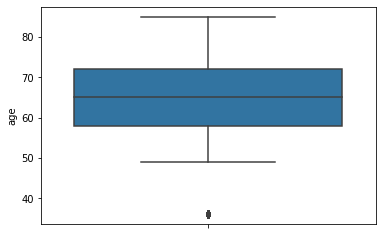

In [23]:
sns.boxplot(y = "age", data = dataset)

We can see that there are a couple of datapoints well below the lower whisker in this boxplot.As can be inferred from the five point summary, it is a series of readings for a patient whose age is 36. Since this age is much below the median age, we can discard any records with age <=36, so as to avoid skew in our data.

In [24]:
  dataset=dataset[dataset['age']>36]

In [25]:
X1 = dataset.iloc[:,0:3]
X2 = dataset.iloc[:,5:]
X = pd.concat([X1,X2],axis = 1)
Y = dataset.iloc[:,3:5]

While using the sklearn function of train_test_split, we will make sure to tune the parameters as per our need. First off, the test_size parameter specifies that the data needs to split into 75% train and 25% test data. The random state parameter is a random value, so that we get an identical split of the original dataset every time. The shuffle variable is set to true, especially since our dataset is ordered patient ID wise, and we would like the records to be shuffled first and then split.

In [26]:
# load and summarize the dataset
from sklearn.model_selection import train_test_split

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=157,shuffle=True)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (4321, 19) (4321, 2)
Test (1441, 19) (1441, 2)


Let's take a look at our training and test datasets to make sure the target variable values are evenly distributed

Text(0.5, 1.0, 'Motor UPDRS Testing data')

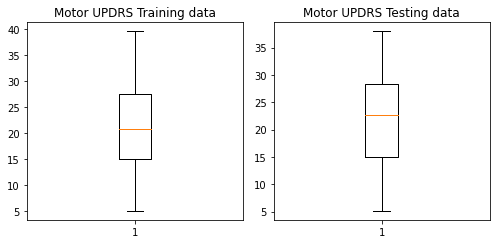

In [27]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
axes[0].boxplot(y_train.iloc[:,0])
axes[0].set_title("Motor UPDRS Training data")
axes[1].boxplot(y_test.iloc[:,0])
axes[1].set_title("Motor UPDRS Testing data")

Text(0.5, 1.0, 'Total UPDRS Testing data')

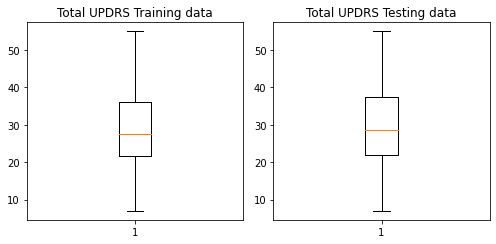

In [28]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
axes[0].boxplot(y_train.iloc[:,1])
axes[0].set_title("Total UPDRS Training data")
axes[1].boxplot(y_test.iloc[:,1])
axes[1].set_title("Total UPDRS Testing data")

We were able to split the dataset evenly into train and test datasets.

### Feature Selection

We will now move onto feature selection. We will be trying a few methods of feature selection in this subsection. 

### Pearson Correlation

We will start with one of the most simple, Pearson correlation. For this purpose we will make use of the inbuild corr() function and then plot the correlation results on a heatmap. This will be done on the whole dataset so that we get a whole look at the correlation between not just the independent and dependent variables, but also at the correlation between the independent variables and take necessary steps to reduce multicollinearity.

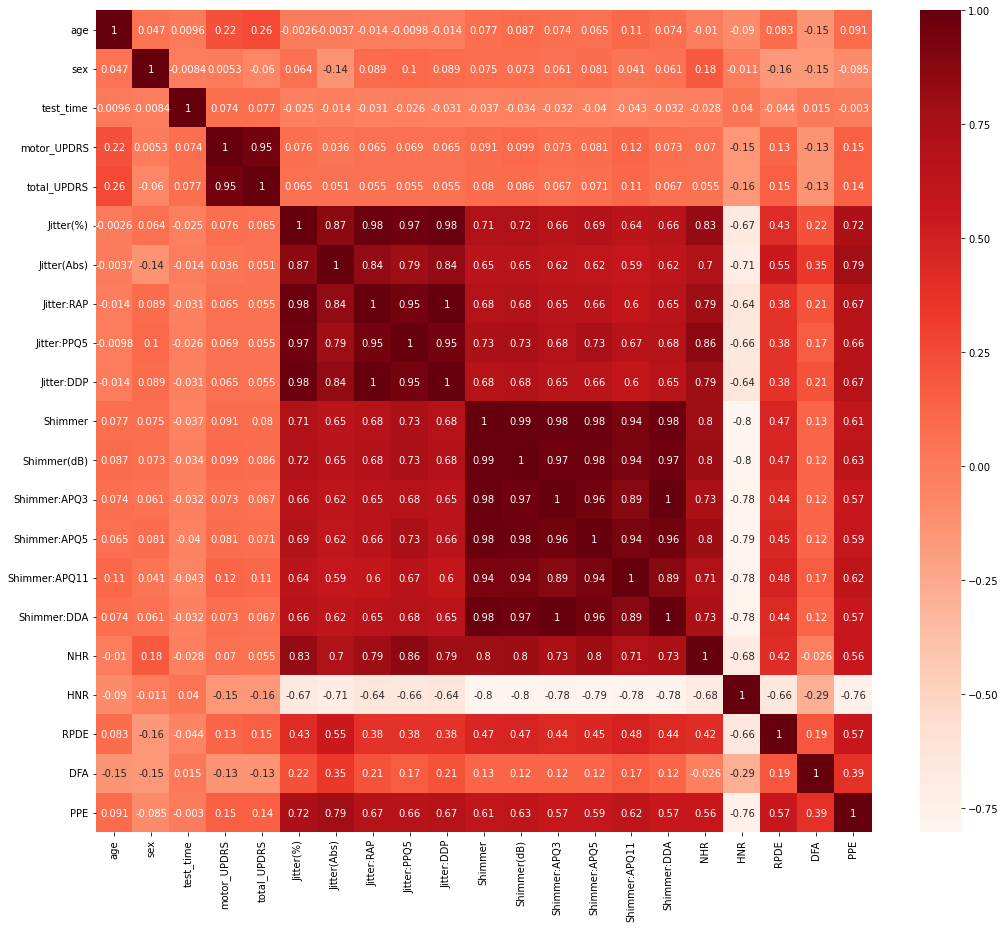

In [29]:
#Using Pearson Correlation
plt.figure(figsize=(15,13))
cor=dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

We can a few observations from this heatmap:

1. Both the target variables - motor_UPDRS and total_UPDRS are highly correlated to each other.
2. The 5 Jitter variables are highly correlated to each other, this means we should be retaining only one of the Jitter variables.
3. The 6 Shimmer variables are highly correlated to each other, this means we should be retaining only one of the Shimmer variables.
4. We can also see a decent level of correlation between the Shimmer and Jitter variables.
5. There are no independent variables which have a high correlation to either of our two target variables.

Let us filter out the relevant variables based on the correlation calculated in the heatmap.

Below are the relevant features that are correlated to the first target variable - motor_UPDRS

In [30]:
#Correlation with output variable
cor_target = abs(cor['motor_UPDRS'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

age              0.220008
motor_UPDRS      1.000000
total_UPDRS      0.945718
Shimmer:APQ11    0.124059
HNR              0.151510
RPDE             0.126663
DFA              0.134748
PPE              0.151100
Name: motor_UPDRS, dtype: float64

Below are the independent variables that are correlated to the second target variable - total_UPDRS

In [31]:
#Correlation with second output variable
cor_target = abs(cor['total_UPDRS'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

age              0.255128
motor_UPDRS      0.945718
total_UPDRS      1.000000
Shimmer:APQ11    0.106798
HNR              0.155659
RPDE             0.154517
DFA              0.133730
PPE              0.143350
Name: total_UPDRS, dtype: float64

Since we are only seeing very low correlation values and as discussed earlier about the heatmap, we are seeing very less correlation to either of the target variables, we can attempt other methods of feature selection.

### F-score

The f-score is a measure of correlation, and the higher it is for a feature, the more likely we are to keep it in our final model. In our case we want to predict two random variables y, this means that we have to look at the correlations with each of them. So first we can make a bar-plot with f-scores the first variable motor UPDRS.

In [32]:
cols=list(dataset.columns)
cols.remove('motor_UPDRS')
cols.remove('total_UPDRS')
cols=np.array(cols)

Feature 0: 219.126592
Feature 1: 0.495753
Feature 2: 19.212765
Feature 3: 28.308949
Feature 4: 7.040995
Feature 5: 21.829491
Feature 6: 23.937857
Feature 7: 21.834703
Feature 8: 39.454326
Feature 9: 45.397221
Feature 10: 27.377488
Feature 11: 31.050990
Feature 12: 66.094167
Feature 13: 27.376410
Feature 14: 24.592722
Feature 15: 108.138546
Feature 16: 75.592208
Feature 17: 79.052936
Feature 18: 104.218618


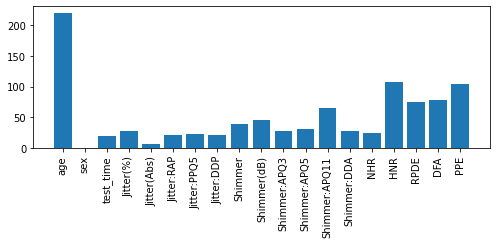

In [33]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from matplotlib import pyplot
 
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train.iloc[:,0], X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

# plot the scores
pyplot.bar([cols[i] for i in range(len(cols))],fs.scores_)
pyplot.xticks(rotation=90)
pyplot.show()

The top important features are 0,18,15,16,17,12 and 9.

We will now plot the f-scores of the correlation with the second variable - total_UPDRS

Feature 0: 304.395446
Feature 1: 11.985504
Feature 2: 21.846901
Feature 3: 20.055545
Feature 4: 12.159860
Feature 5: 15.543332
Feature 6: 15.285543
Feature 7: 15.546400
Feature 8: 28.373318
Feature 9: 32.736510
Feature 10: 21.169347
Feature 11: 22.361782
Feature 12: 46.955339
Feature 13: 21.169153
Feature 14: 15.080944
Feature 15: 110.881109
Feature 16: 109.993625
Feature 17: 78.738572
Feature 18: 88.431337


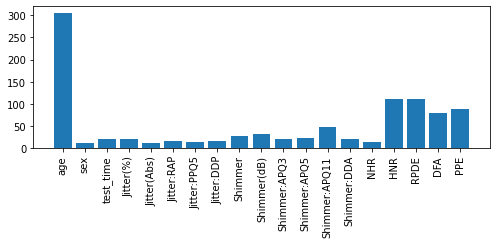

In [34]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train.iloc[:,1], X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

# plot the scores
pyplot.bar([cols[i] for i in range(len(cols))],fs.scores_)
pyplot.xticks(rotation=90)
pyplot.show()

The top important features are : 0,15,16,18,17,12 and 9.

### Mutual Information Feature Selection

This is a measure derived from information theory. Mutual information is calculated between two variables and measures the reduction of uncertainty for a random variable, considering the value of another random variable known. It can be used in a similar way as the f-score. Therefore we can consider that the k best features are those with the most mutual information.

We will first identify the important features for our first target variable - motor_UPDRS

Feature 0: 2.727552
Feature 1: 0.523372
Feature 2: 5.751081
Feature 3: 0.100380
Feature 4: 0.111572
Feature 5: 0.072956
Feature 6: 0.106501
Feature 7: 0.074657
Feature 8: 0.102646
Feature 9: 0.066893
Feature 10: 0.105921
Feature 11: 0.093909
Feature 12: 0.097539
Feature 13: 0.105675
Feature 14: 0.103987
Feature 15: 0.149933
Feature 16: 0.094487
Feature 17: 0.192619
Feature 18: 0.096941


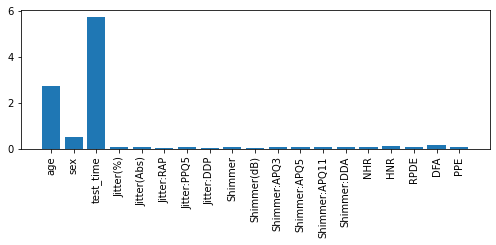

In [35]:
# example of mutual information feature selection for numerical input data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=mutual_info_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train.iloc[:,0], X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

# plot the scores
pyplot.bar([cols[i] for i in range(len(cols))],fs.scores_)
pyplot.xticks(rotation=90)
pyplot.show()

Features 2,0 and 1 clearly standout.


We will now run the same test for the target variable - total_UPDRS

Feature 0: 2.720259
Feature 1: 0.536653
Feature 2: 5.920221
Feature 3: 0.089739
Feature 4: 0.118434
Feature 5: 0.081617
Feature 6: 0.138263
Feature 7: 0.081878
Feature 8: 0.103911
Feature 9: 0.087527
Feature 10: 0.087678
Feature 11: 0.093119
Feature 12: 0.114427
Feature 13: 0.088283
Feature 14: 0.081031
Feature 15: 0.140444
Feature 16: 0.068400
Feature 17: 0.197796
Feature 18: 0.097156


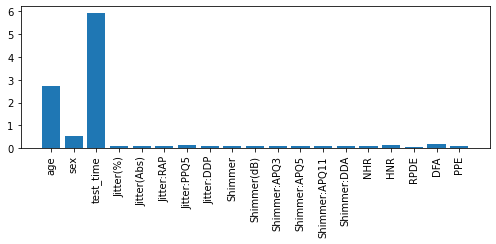

In [36]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train.iloc[:,1], X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([cols[i] for i in range(len(cols))],fs.scores_)
pyplot.xticks(rotation=90)
pyplot.show()

We are seeing similar trends as in features 2, 0 and 1 are coming up as important.

### Recursive Feature Elimination

Another way for efficient feature selection is to make use of a machine learning classifier or regressor and test it repeatedly in subsets of our original dataset until we find which set of features provide the best prediction on the picked algorithm.

Since this is a compute intensive process, we will be only testing out one such method - RFE (Recursive Feature Elimination)

RFE typically takes two input parameters :
1. The machine learning algorithm of our choice to which the data will be fitted repeatedly until the subset of features is found which gives the best accuracy.
2. The number of resultant features, this is an optional parameter, and when specified, the RFE model returns that number of features that are the most important.

In our example here, we will use the RFECV model, which does not need the number of features parameter, and will only need the machine learning algorithm to be specified. We will first attempt to run the RFECV using a Linear Regression model on our dataset. We will first attempt to predict motor_UPDRS.

In [37]:
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFECV
model = LinearRegression()
#Initializing RFE model
rfe = RFECV(estimator=LinearRegression())
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train.iloc[:,0])  
#Fitting the data to model
model.fit(X_rfe,y_train.iloc[:,0])
print(rfe.support_)
print(rfe.ranking_)
cols=list(dataset.columns)
cols.remove('motor_UPDRS')
cols.remove('total_UPDRS')
for i in range(X.shape[1]):
	print('Column: %s, %s, Rank: %.3f' % (cols[i], rfe.support_[i], rfe.ranking_[i]))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Column: age, True, Rank: 1.000
Column: sex, True, Rank: 1.000
Column: test_time, True, Rank: 1.000
Column: Jitter(%), True, Rank: 1.000
Column: Jitter(Abs), True, Rank: 1.000
Column: Jitter:RAP, True, Rank: 1.000
Column: Jitter:PPQ5, True, Rank: 1.000
Column: Jitter:DDP, True, Rank: 1.000
Column: Shimmer, True, Rank: 1.000
Column: Shimmer(dB), True, Rank: 1.000
Column: Shimmer:APQ3, True, Rank: 1.000
Column: Shimmer:APQ5, True, Rank: 1.000
Column: Shimmer:APQ11, True, Rank: 1.000
Column: Shimmer:DDA, True, Rank: 1.000
Column: NHR, True, Rank: 1.000
Column: HNR, True, Rank: 1.000
Column: RPDE, True, Rank: 1.000
Column: DFA, True, Rank: 1.000
Column: PPE, True, Rank: 1.000


The results are a sightly inconsistent here, as we can see, the linear regressor classifier has determined all the features as important. However we have seen in the previous analyses that there is a lot of multicollinearity and hence Linear Regression is not a good fit model for this dataset.

We will now try RFECV with a Decision tree regression for the first target variable - motor_UPDRS.

In [38]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
#Initializing RFE model
rfe = RFECV(estimator=DecisionTreeRegressor())
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train.iloc[:,0])  
#Fitting the data to model
model.fit(X_rfe,y_train.iloc[:,0])
print(rfe.support_)
print(rfe.ranking_)
cols=list(dataset.columns)
cols.remove('motor_UPDRS')
cols.remove('total_UPDRS')
for i in range(X.shape[1]):
	print('Column: %s, %s, Rank: %.3f' % (cols[i], rfe.support_[i], rfe.ranking_[i]))

[ True  True  True False False False False False False False False False
 False False False False False False False]
[ 1  1  1 17  3 15 13  7  4 14  6 10 12 16  8  5 11  2  9]
Column: age, True, Rank: 1.000
Column: sex, True, Rank: 1.000
Column: test_time, True, Rank: 1.000
Column: Jitter(%), False, Rank: 17.000
Column: Jitter(Abs), False, Rank: 3.000
Column: Jitter:RAP, False, Rank: 15.000
Column: Jitter:PPQ5, False, Rank: 13.000
Column: Jitter:DDP, False, Rank: 7.000
Column: Shimmer, False, Rank: 4.000
Column: Shimmer(dB), False, Rank: 14.000
Column: Shimmer:APQ3, False, Rank: 6.000
Column: Shimmer:APQ5, False, Rank: 10.000
Column: Shimmer:APQ11, False, Rank: 12.000
Column: Shimmer:DDA, False, Rank: 16.000
Column: NHR, False, Rank: 8.000
Column: HNR, False, Rank: 5.000
Column: RPDE, False, Rank: 11.000
Column: DFA, False, Rank: 2.000
Column: PPE, False, Rank: 9.000


The RFE has given us three features that are most important to predict motor_UPDRS namely, age, sex and test_time. This is consistent with our previous analyses as well. 

We will now run RFE for total_UPDRS.

In [39]:
model = DecisionTreeRegressor()
#Initializing RFE model
rfe = RFECV(estimator=DecisionTreeRegressor())
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train.iloc[:,1])  
#Fitting the data to model
model.fit(X_rfe,y_train.iloc[:,1])
print(rfe.support_)
print(rfe.ranking_)
cols=list(dataset.columns)
cols.remove('motor_UPDRS')
cols.remove('total_UPDRS')
for i in range(X.shape[1]):
	print('Column: %s, %s, Rank: %.3f' % (cols[i], rfe.support_[i], rfe.ranking_[i]))

[ True  True  True False False False False False False False False False
 False False False  True False  True False]
[ 1  1  1  3  4  6 15 11 12 13 14  5  7  9  8  1  2  1 10]
Column: age, True, Rank: 1.000
Column: sex, True, Rank: 1.000
Column: test_time, True, Rank: 1.000
Column: Jitter(%), False, Rank: 3.000
Column: Jitter(Abs), False, Rank: 4.000
Column: Jitter:RAP, False, Rank: 6.000
Column: Jitter:PPQ5, False, Rank: 15.000
Column: Jitter:DDP, False, Rank: 11.000
Column: Shimmer, False, Rank: 12.000
Column: Shimmer(dB), False, Rank: 13.000
Column: Shimmer:APQ3, False, Rank: 14.000
Column: Shimmer:APQ5, False, Rank: 5.000
Column: Shimmer:APQ11, False, Rank: 7.000
Column: Shimmer:DDA, False, Rank: 9.000
Column: NHR, False, Rank: 8.000
Column: HNR, True, Rank: 1.000
Column: RPDE, False, Rank: 2.000
Column: DFA, True, Rank: 1.000
Column: PPE, False, Rank: 10.000


As for total_UPDRS, the RFECV DecisionTree has returned 5 important features namely - age, sex, test_time, RPDE,DFA.


With the 4 methods we have tried to identify the important features, we can conclude the below:

1. For motor_UPDRS target variable : 
The most important features are Age, Sex and test_time. The lesser important variables but still relevant are : HNR,RPDE,DFA and PPE (As per F-scores and Pearson Correlation)

2. For total_UPDRS target variable :
The most important features are Age, Sex, test_time, RPDE, DFA. The lesser important variables but still relevant are : HNR and PPE (as per f-scores and Pearson Correlation)


In [40]:
cols = ['age','sex','test_time','HNR','RPDE','DFA','PPE']
X_train_final = X_train[cols]
X_test_final = X_test[cols]

## Training Xgboost model

In [41]:
import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(X_train_final,y_train.iloc[:,0])
preds = model.predict(X_test_final)
print("\nMotor UPDRS")
print('Mean absolute error: ',round(np.mean(abs(preds - y_test.iloc[:,0])),3))
print("Root Mean Squared error: ",(np.sqrt(np.mean((preds - y_test.iloc[:,0])**2))).round(3))

model = xgb.XGBRegressor()
model.fit(X_train_final,y_train.iloc[:,1])
preds = model.predict(X_test_final)
print("\nTotal UPDRS")
print('Mean absolute error: ',round(np.mean(abs(preds - y_test.iloc[:,1])),3))
print("Root Mean Squared error: ",round(np.sqrt(np.mean((preds - y_test.iloc[:,1])**2)),3))

[17:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Motor UPDRS
Mean absolute error:  2.866
Root Mean Squared error:  3.688
[17:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Total UPDRS
Mean absolute error:  3.443
Root Mean Squared error:  4.436


## Training SVR model

In [42]:
from sklearn.svm import SVR

model = SVR(kernel='rbf')
model.fit(X_train_final,y_train.iloc[:,0])
preds = model.predict(X_test_final)
print("\nMotor UPDRS")
print('Mean absolute error: ',round(np.mean(abs(preds - y_test.iloc[:,0])),3))
print("Root Mean Squared error: ",(np.sqrt(np.mean((preds - y_test.iloc[:,0])**2))).round(3))


model.fit(X_train_final,y_train.iloc[:,1])
preds = model.predict(X_test_final)
print("\nTotal UPDRS")
print('Mean absolute error: ',round(np.mean(abs(preds - y_test.iloc[:,1])),3))
print("Root Mean Squared error: ",(np.sqrt(np.mean((preds - y_test.iloc[:,1])**2))).round(3))




Motor UPDRS
Mean absolute error:  6.81
Root Mean Squared error:  7.935

Total UPDRS
Mean absolute error:  8.593
Root Mean Squared error:  10.722


In [80]:
from sklearn import datasets, preprocessing
X_train_array = np.array(X_train_final)
X_test_array = np.array(X_test_final)
data_scaler = preprocessing.MinMaxScaler((0,1))
target_scaler = preprocessing.MinMaxScaler((0,1))

X_train_array = data_scaler.fit_transform(X_train_array)
X_test_array = data_scaler.fit_transform(X_test_array)
y_train_val = target_scaler.fit_transform(np.array(y_train.iloc[:,0]).reshape(-1,1))

In [89]:
from neupy import algorithms
from neupy.layers import *


network = Input(7) >> Relu(5) >> Relu(4) >> Relu(3)>> Relu(2) >> Linear(1)
optimizer = algorithms.RPROP(network)

optimizer.train(X_train_array, y_train_val,epochs = 1000)
preds = optimizer.predict(np.array(X_test_array))
preds = target_scaler.inverse_transform(preds)
print("\nMotor UPDRS")
print('Mean absolute error: ',round(np.mean(abs(preds - np.array(y_test.iloc[:,0]))),3))
print("Root Mean Squared error: ",(np.sqrt(np.mean((preds - np.array(y_test.iloc[:,0]))**2))).round(3))


Motor UPDRS
Mean absolute error:  7.018
Root Mean Squared error:  8.144


In [90]:


y_train_val = target_scaler.fit_transform(np.array(y_train.iloc[:,1]).reshape(-1,1))
network = Input(7) >> Relu(5) >> Relu(4) >> Relu(3)>> Relu(2) >> Linear(1)
optimizer = algorithms.RPROP(network)

optimizer.train(X_train_array, y_train_val,epochs = 1000)
preds = optimizer.predict(np.array(X_test_array))
preds = target_scaler.inverse_transform(preds)

print("\nTotal UPDRS")
print('Mean absolute error: ',round(np.mean(abs(preds - np.array(y_test.iloc[:,1]))),3))
print("Root Mean Squared error: ",(np.sqrt(np.mean((preds - np.array(y_test.iloc[:,1]))**2))).round(3))


Total UPDRS
Mean absolute error:  10.132
Root Mean Squared error:  12.539


##References

1. Athanasios Tsanas, Max A. Little, Patrick E. McSharry, Lorraine O. Ramig (2009), 
'Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests', 
IEEE Transactions on Biomedical Engineering (to appear). 
2. Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2009), 
'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', 
IEEE Transactions on Biomedical Engineering, 56(4):1015-1022 
3. https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring
4. https://www.kaggle.com/blackpianocat/parkinson
5. https://machinelearningmastery.com/
6. https://github.com/nikbearbrown
7. https://stackoverflow.com/
8. https://www.itl.nist.gov/div898/handbook/eda/section3/eda3665.htm 
9. https://towardsdatascience.com/
10.https://scikit-learn.org/
11.Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

Copyright 2021 | Basil Varghese

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.